<h1>Analysis of Azog C1 chip: bright side</h1>
Online analysis script used to pre-analyse the data collected during the cooldown of the chip.

In [1]:
sample_name = 'azog_c1'                    # name of the chip in the fridge
date_suffixe = '20220203'
user = 'ncr'                               # who is performing measurements

<h3>Basic imports and database loading</h3>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from resonator_tools import circuit

import qcodes as qc
from qcodes import initialise_database, load_by_run_spec
from qcodes.dataset.plotting import plot_by_id

import scipy.optimize

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
db_name = 'bright_side_v1.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',date_suffixe+'_'+user+'_'+ db_name)

db_name_2t = 'chip_characterisation_v2.db'   # name of the database
db_path_2t  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\','20220131'+'_'+user+'_'+ db_name_2t)

<h2>Data analysis and plotting</h2>

<h4>IV of the Bloch array as a function of the applied flux</h4>

In [3]:
# loading 2tones
qc.initialise_or_create_database_at(db_path_2t)

RUN_ID = 19 # 22
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
twotf_dict = dataset.to_pandas_dataframe_dict()

# loading IV and s21
qc.initialise_or_create_database_at(db_path)

RUN_ID = 2
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
ivf_dict = dataset.to_pandas_dataframe_dict()

RUN_ID = 10
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
s21f_dict = dataset.to_pandas_dataframe_dict()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\NICOLA~1.ROC\AppData\Local\Temp/ipykernel_12732/910832413.py", line 17, in <module>
    s21f_dict = dataset.to_pandas_dataframe_dict()
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\dataset\data_set.py", line 943, in to_pandas_dataframe_dict
    datadict = self.get_parameter_data(*params,
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\dataset\data_set.py", line 897, in get_parameter_data
    return get_parameter_data(self.conn, self.table_name,
  File "C:\Users\nicolas.roch\Miniconda3\envs\measurement\lib\site-packages\qcodes\dataset\sqlite\queries.py", line 212, in get_parameter_data
    output[output_param] = get_shaped_parameter_data_for_one_paramtree(
  File "C:\Users\nicolas

TypeError: object of type 'NoneType' has no len()

<h5>Data shaping</h5>

In [5]:
# IV
# up ramp
ivf_up_0 = ivf_dict['adwin_up_ramp']
ivf_up_1 = ivf_up_0.reset_index()
v_up = ivf_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = ivf_up_1['adwin_up_ramp'].to_numpy()

# down ramp
ivf_down_0 = ivf_dict['adwin_down_ramp']
ivf_down_1 = ivf_down_0.reset_index()
v_down = ivf_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = ivf_down_1['adwin_down_ramp'].to_numpy()

In [6]:
# twotones
twot_vna_0 = twotf_dict['ZNB20_S21_magnitude']
twot_vna_1 = twot_vna_0.reset_index()

frq_tt = twot_vna_1['mw_source_frequency'].to_numpy()
mw_p = twot_vna_1['mw_source_power'].to_numpy()
mag_tt = twot_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq_tt).size)
frq_tt = np.reshape(frq_tt, m_size)
mw_p = np.reshape(mw_p, m_size)
mag_tt = np.reshape(mag_tt, m_size)

In [7]:
# s21
s21bs_vna_0 = s21f_dict['ZNB20_S21_magnitude']
s21bs_vna_1 = s21bs_vna_0.reset_index()

frq_s21 = s21bs_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = s21bs_vna_1['adwin_output1'].to_numpy()
mag_s21 = s21bs_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq_s21).size)
frq_s21 = np.reshape(frq_s21, m_size)
v_bias = np.reshape(v_bias, m_size)
mag_s21 = np.reshape(mag_s21, m_size)

<h5>Plotting</h5>

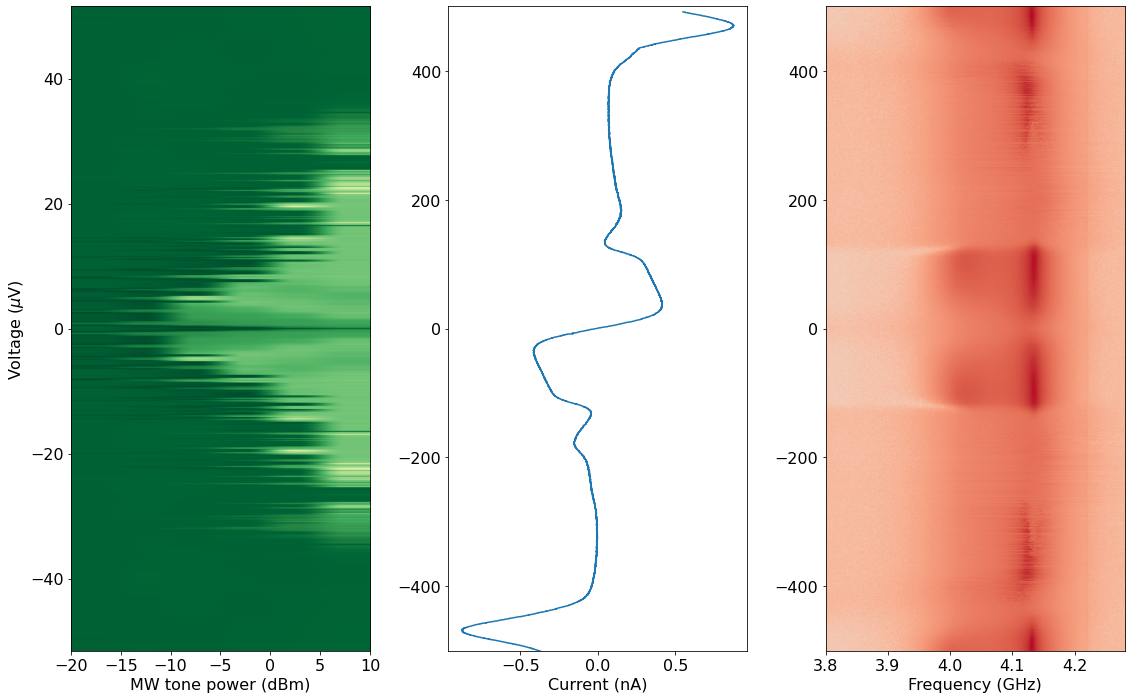

In [8]:
# constants 
voltage_scale = 1e6
current_scale = 1e9
frequency_scale = 1e-9
hbar = 1.05e-34
e = 1.60e-19
HztoV = 2*np.pi*hbar/2/e

# plotting
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 3, figsize=(16,10))

# two-tones shaping
twotones_sym = np.rot90( np.hstack(( np.flip(mag_tt[::-1]), mag_tt )) )
fmin = -np.min(frq_tt)
fmax = np.max(frq_tt)

ax[0].imshow(np.log(twotones_sym), aspect='auto', cmap='YlGn',
             extent = [np.min(mw_p), np.max(mw_p), -HztoV*fmax*voltage_scale, HztoV*fmax*voltage_scale] )

ax[1].plot(current_scale*i_up, voltage_scale*v_up)
ax[1].vlines(0, -0.5, 0.5, alpha=0.5, linestyles='dashed')
ax[1].set_ylim(-500, 500)

s21_start = 3500
s21_stop = 4100
v_start = 0
v_stop = -1

ax[2].imshow(np.log(mag_s21[v_start:v_stop,s21_start:s21_stop]), aspect='auto', cmap='coolwarm', 
             extent = [frequency_scale*frq_s21[0][s21_start], frequency_scale*frq_s21[0][s21_stop], 
                       voltage_scale*v_bias[v_start][0]/1e3, voltage_scale*v_bias[v_stop][0]/1e3] )

ax[0].set_xlabel('MW tone power (dBm)')
ax[0].set_ylabel('Voltage ($\mu$V)')

ax[1].set_xlabel('Current (nA)')
ax[2].set_xlabel('Frequency (GHz)')

fig.tight_layout()
plt.savefig('brightside_it.png')

<h5>Distribution of the current peaks not at $2\Delta$</h5>

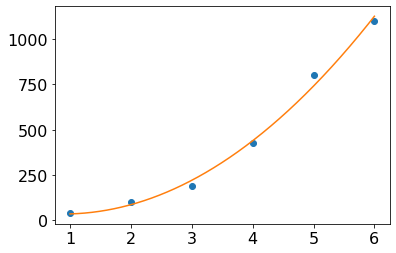

In [9]:
n = np.linspace(1, 6, 6)
peaks = [37, 100, 186, 424, 800, 1100]

fit_par = np.polyfit(n, peaks, 2)
fit = np.poly1d(fit_par)

plt.plot( n, peaks, 'o' )
plt.plot( np.linspace(1,6,1001), fit(np.linspace(1,6,1001)) )

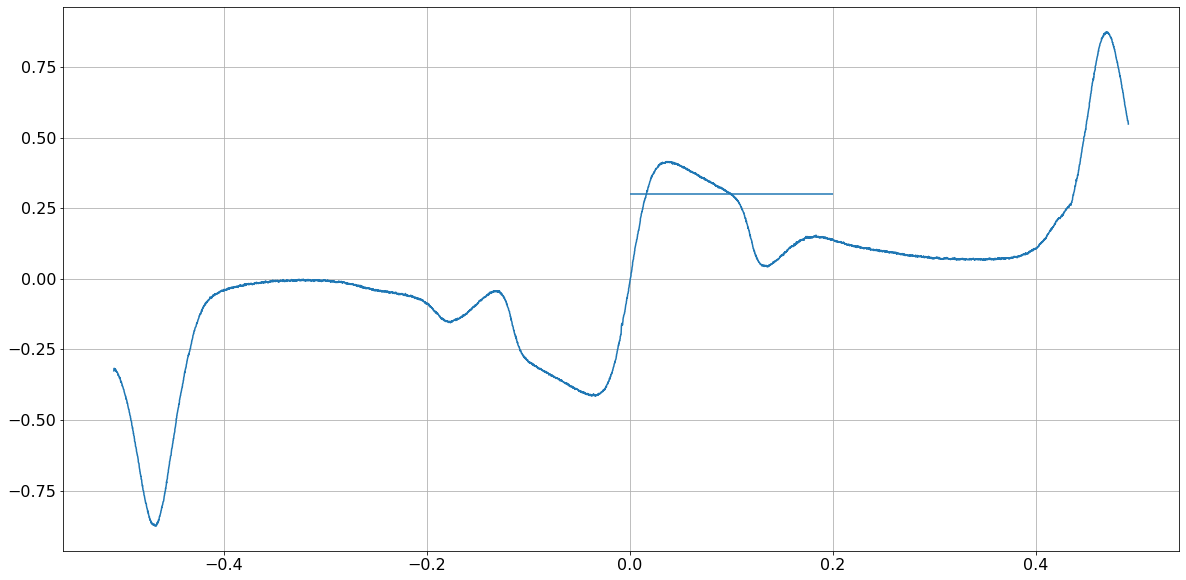

In [25]:
plt.figure(figsize=(20,10))
voltage_scale =1e3
plt.plot(voltage_scale*v_up, current_scale*i_up)
plt.hlines([0.3], 0,0.2)
plt.grid()
# plt.xlim([-10,10])
# plt.ylim([-0.5,0.5])